# Check Neural Collapse in Standard Training

In [1]:
from jaxl.constants import *
from jaxl.datasets.mnist import construct_mnist
from jaxl.datasets.wrappers import StandardSupervisedDataset
from jaxl.learning_utils import get_learner
from jaxl.models.common import get_activation
from jaxl.models.modules import CNNModule, MLPModule
from jaxl.plot_utils import set_size
from jaxl.utils import parse_dict, get_device

import _pickle as pickle
import argparse
import jax
import jax.random as jrandom
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.datasets as torch_datasets

from collections import OrderedDict
from functools import partial
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager
from torch.utils.data import DataLoader
from types import SimpleNamespace

In [2]:
device = "cpu"
get_device(device)

In [3]:
doc_width_pt = 750.0

learner_path = "/Users/chanb/research/personal/jaxl/{}".format(
    # "jaxl/logs/nc-mnist/cnn-01-19-24_19_37_18-8c04f541-01bc-4346-be64-5581bceb4cc2"
    # "jaxl/logs/nc-mnist/cnn-01-20-24_13_07_31-33ace545-993f-4c19-880d-7b5160b37403"
    # "jaxl/logs/nc-mnist/cnn-01-20-24_16_22_52-7a22c1a3-7367-41aa-a9c6-80c545836bbd"
    # "jaxl/logs/nc-mnist/cnn-01-20-24_18_14_43-62e223df-3f90-4360-b4f6-a7324c0d214f"
    "jaxl/logs/nc-mnist/cnn-dim_2-deeper-01-21-24_19_23_29-709584d1-9fec-41dc-bd84-995acd69953a"
    # "jaxl/logs/nc-mnist/cnn-dim_10-01-21-24_19_19_07-86bb075d-6689-4244-b86b-f3dde0955be2"
)

exp_name = "-".join(learner_path.split("/")[-1].split("-")[:-8])

In [4]:
def load_model(learner_path: str):
    config_path = os.path.join(learner_path, "config.json")
    with open(config_path, "r") as f:
        config_dict = json.load(f)
        config = parse_dict(config_dict)

    learner = get_learner(
        config.learner_config, config.model_config, config.optimizer_config
    )

    checkpoint_manager = CheckpointManager(
        os.path.join(learner_path, "models"),
        PyTreeCheckpointer(),
    )

    params = checkpoint_manager.restore(checkpoint_manager.latest_step())
    all_params = [(step, checkpoint_manager.restore(step)) for step in checkpoint_manager.all_steps()]
    model = learner._model
    return params, model, config, all_params

In [5]:
params, model, config, all_params = load_model(learner_path)

In [6]:
config

namespace(logging_config=namespace(save_path='./logs/nc-mnist',
                                   experiment_name='cnn-dim_2-deeper',
                                   log_interval=10,
                                   checkpoint_interval=100),
          model_config=namespace(architecture='cnn',
                                 features=[32, 32, 32],
                                 kernel_sizes=[[3, 3], [3, 3], [3, 3]],
                                 layers=[32, 32, 2]),
          optimizer_config=namespace(optimizer='adam',
                                     lr=namespace(scheduler='constant_schedule',
                                                  scheduler_kwargs=namespace(value=0.0003)),
                                     max_grad_norm=False),
          learner_config=namespace(task='supervised_learning',
                                   dataset_config=namespace(dataset_name='mnist',
                                                            dataset_kwargs=namespace

In [7]:
train_dataset = StandardSupervisedDataset(construct_mnist(
    config.learner_config.dataset_config.dataset_kwargs.save_path,
    train=True,
))

test_dataset = StandardSupervisedDataset(construct_mnist(
    config.learner_config.dataset_config.dataset_kwargs.save_path,
    train=False,
))

In [8]:
def get_latent(params, inputs, carries):
    cnn_outs, cnn_states = CNNModule(
        config.model_config.features,
        config.model_config.kernel_sizes,
        get_activation(CONST_RELU),
    ).apply(
        {"params": params[CONST_MODEL_DICT][CONST_MODEL][CONST_CNN][CONST_PARAMS]},
        inputs,
        capture_intermediates=True,
        mutable=["cnn_latents"]
    )

    cnn_outs = cnn_outs.reshape((len(cnn_outs), -1))

    _, mlp_states = MLPModule(
        config.model_config.layers,
        get_activation(CONST_RELU),
        get_activation(CONST_IDENTITY),
    ).apply(
        {"params": params[CONST_MODEL_DICT][CONST_MODEL][CONST_MLP][CONST_PARAMS]},
        cnn_outs,
        capture_intermediates=True,
        mutable=["mlp_latents"]
    )

    latents = OrderedDict()
    for (states, key) in [
        (cnn_states, "cnn_latents"),
        (mlp_states, "mlp_latents"),
    ]:
        for state, state_val in states[key].items():
            latents[state] = state_val
    return latents

In [9]:
def plot(mlp_1_latents, labels, step):
    os.makedirs("./imgs/{}".format(exp_name), exist_ok=True)
    nrows = 1
    ncols = 2
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    unique_classes = np.unique(labels["train"])

    for ax_i, key in enumerate(("train", "test")):
        for class_i in unique_classes:
            class_idxes = np.where(labels[key] == class_i)[0]
            axes[ax_i].scatter(
                mlp_1_latents[key][class_idxes, 0],
                mlp_1_latents[key][class_idxes, 1],
                label="Class {}".format(class_i) if ax_i == 0 else "",
                alpha=0.5,
                s=1
            )
        axes[ax_i].set_title(key)
    fig.legend()
    fig.suptitle("Model @ epoch {}".format(step))
    fig.tight_layout()
    plt.savefig("./imgs/{}/nc-step_{:08d}.png".format(exp_name, step), format="png", bbox_inches="tight", dpi=600)
    plt.close()

In [10]:
batch_size = 300
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

In [16]:
results = {}
for (step, params) in all_params:
    mlp_1_latents = {
        "train": [],
        "test": [],
    }
    labels = {
        "train": [],
        "test": [], 
    }
    all_latents = {
        "train": {},
        "test": {}
    }

    for key, dataloader in (("train", train_dataloader), ("test", test_dataloader)):
        for batch_i, (inputs, carries, outputs, _) in enumerate(iter(dataloader)):
            latents = get_latent(params, inputs, carries)
            mlp_1_latents[key].append(latents["mlp_{}".format(len(config.model_config.layers) - 1)][0])
            labels[key].append(outputs)
            for k in latents:
                all_latents[key].setdefault(k, [])
                all_latents[key][k].append(latents[k][0])

        mlp_1_latents[key] = np.concatenate(mlp_1_latents[key], axis=0)
        labels[key] = np.concatenate(labels[key], axis=0)
        all_latents[key] = {k: np.concatenate(all_latents[key][k]) for k in all_latents[key]}
    plot(mlp_1_latents, labels, step)
    results[step] = {
        "latents": all_latents,
        "labels": labels,
    }

/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_80874/1143412859.py:27: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [12]:
import imageio

with imageio.get_writer("./nc-{}.gif".format(exp_name), mode='I', duration=100) as writer:
    img_dir = "./imgs/{}".format(exp_name)
    for filename in sorted(os.listdir(img_dir)):
        if not filename.startswith("nc-step"):
            continue
        image = imageio.imread(os.path.join(img_dir, filename))
        writer.append_data(image)

/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_80874/4202823813.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(img_dir, filename))


# Check Neural Collapse Properties

In [13]:
nc_results = {}
for step, step_res in results.items():
    valid_classes = np.unique(step_res["labels"]["train"])
    nc_results.setdefault(step, {})
    # for phase, phase_latents in step_res["latents"].items():
    for phase in ["train"]:
        phase_latents = step_res["latents"][phase]
        for layer, curr_latents in phase_latents.items():
            if layer.startswith("cnn"):
                continue
            nc_results[step].setdefault(layer, {})
            nc_results[step][layer]["global_means"] = np.mean(curr_latents, axis=0)
            offset = (curr_latents - nc_results[step][layer]["global_means"][None])[..., None]
            nc_results[step][layer]["train_total_cov"] = np.mean(offset @ np.transpose(offset, (0, 2, 1)), axis=0)

            nc_results[step][layer]["class_means"] = {}
            for class_i in valid_classes:
                class_idxes = np.where(step_res["labels"][phase] == class_i)[0]
                nc_results[step][layer]["class_means"][class_i] = np.mean(curr_latents[class_idxes], axis=0)
            between_class_offset = np.vstack([nc_results[step][layer]["class_means"][class_i] - nc_results[step][layer]["global_means"] for class_i in valid_classes])[..., None]
            nc_results[step][layer]["between_class_cov"] = np.mean(between_class_offset @ np.transpose(between_class_offset, (0, 2, 1)), axis=0)
            nc_results[step][layer]["within_class_cov"] = np.mean(
                np.concatenate(
                    [curr_latents[np.where(step_res["labels"][phase] == class_i)[0]] - nc_results[step][layer]["class_means"][class_i][None] for class_i in valid_classes],
                    axis=0
                ),
                axis=0
            )
            

In [14]:
jax.tree_map(lambda x: x.shape, nc_results[step])

{'mlp_0': {'between_class_cov': (32, 32),
  'class_means': {0: (32,),
   1: (32,),
   2: (32,),
   3: (32,),
   4: (32,),
   5: (32,),
   6: (32,),
   7: (32,),
   8: (32,),
   9: (32,)},
  'global_means': (32,),
  'train_total_cov': (32, 32),
  'within_class_cov': (32,)},
 'mlp_1': {'between_class_cov': (32, 32),
  'class_means': {0: (32,),
   1: (32,),
   2: (32,),
   3: (32,),
   4: (32,),
   5: (32,),
   6: (32,),
   7: (32,),
   8: (32,),
   9: (32,)},
  'global_means': (32,),
  'train_total_cov': (32, 32),
  'within_class_cov': (32,)},
 'mlp_2': {'between_class_cov': (2, 2),
  'class_means': {0: (2,),
   1: (2,),
   2: (2,),
   3: (2,),
   4: (2,),
   5: (2,),
   6: (2,),
   7: (2,),
   8: (2,),
   9: (2,)},
  'global_means': (2,),
  'train_total_cov': (2, 2),
  'within_class_cov': (2,)}}

## NC1

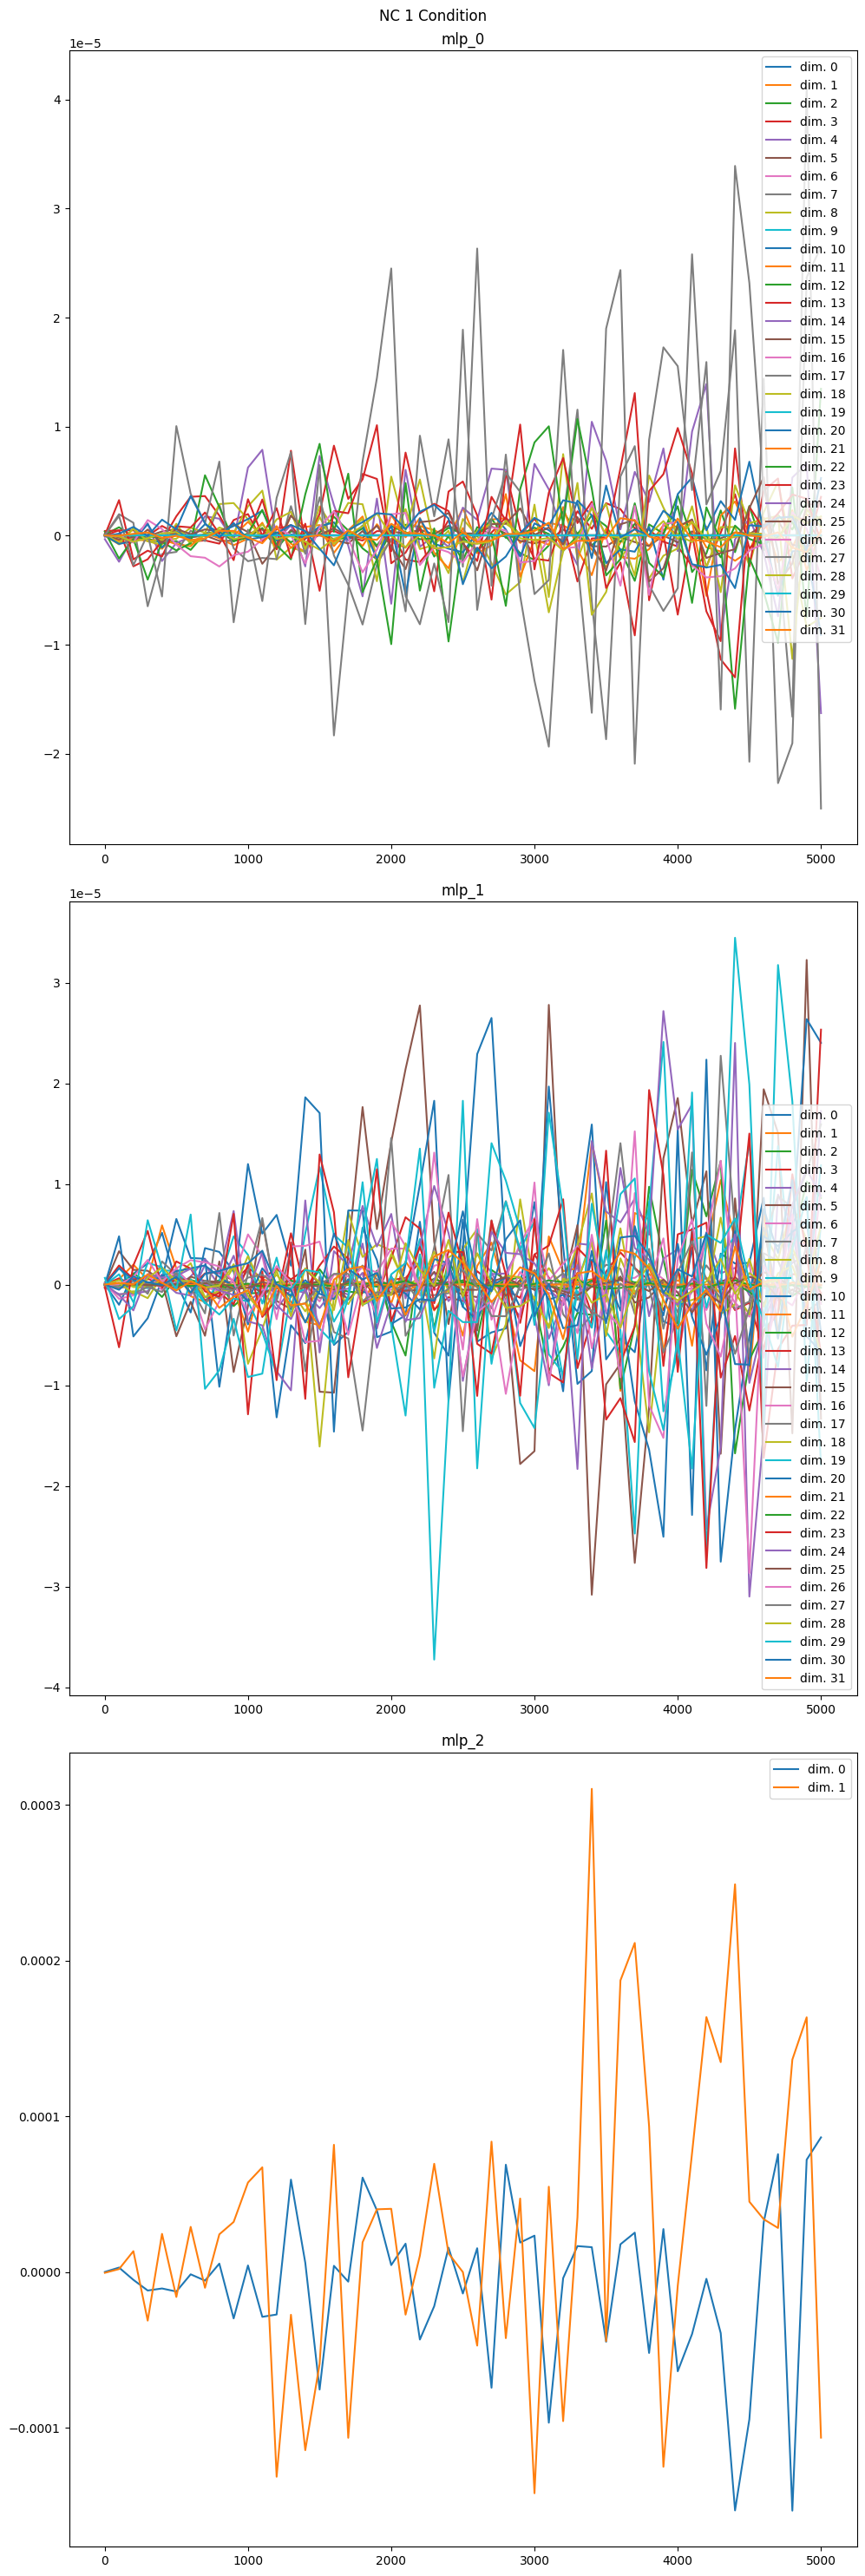

In [15]:
nrows = len(nc_results[1])
ncols = 1
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
    layout="constrained",
)


for ax_i, layer in enumerate(nc_results[1]):
    within_class_cov = np.array([nc_results[step][layer]["within_class_cov"] for step in nc_results])
    for dim_i in range(within_class_cov.shape[1]):
        axes[ax_i].plot(
            nc_results.keys(),
            within_class_cov[:, dim_i],
            label="dim. {}".format(dim_i)
        )
    axes[ax_i].set_title(layer)
    axes[ax_i].legend()
fig.suptitle("NC 1 Condition")
plt.show()
plt.close()